Main dataset shape: (43, 34)
record_type
observation    30
event          10
target          3
Name: count, dtype: int64


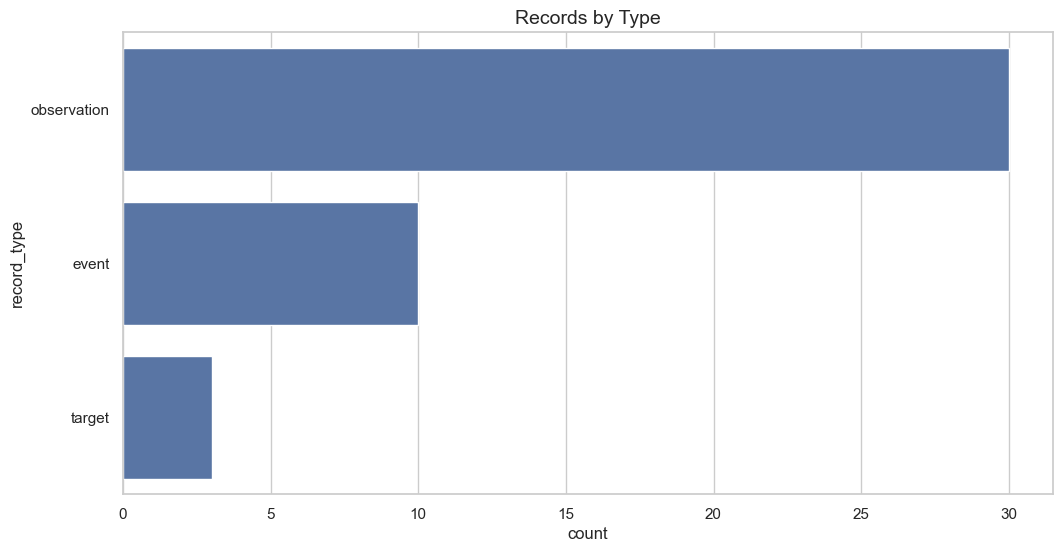

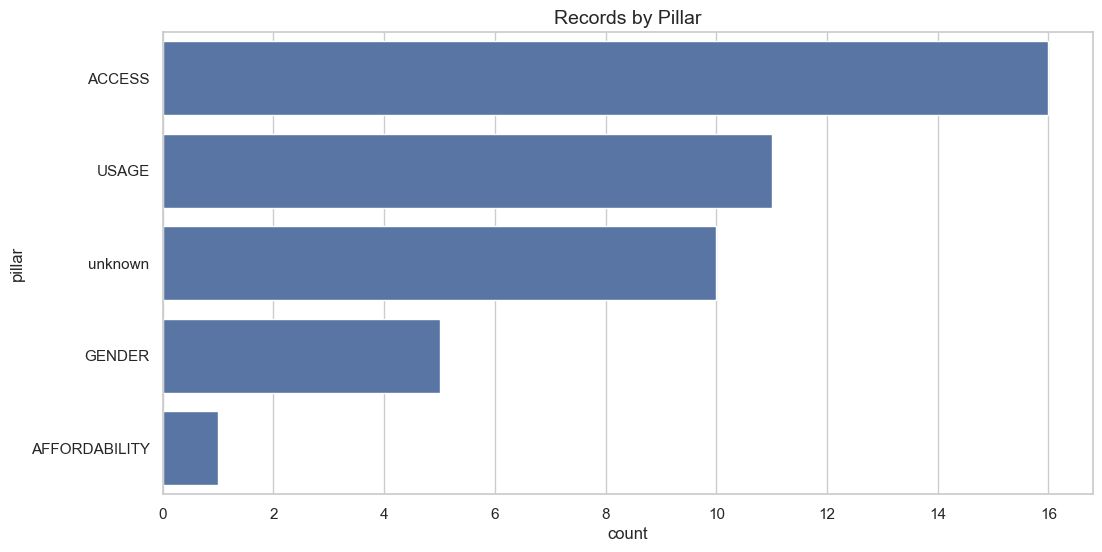

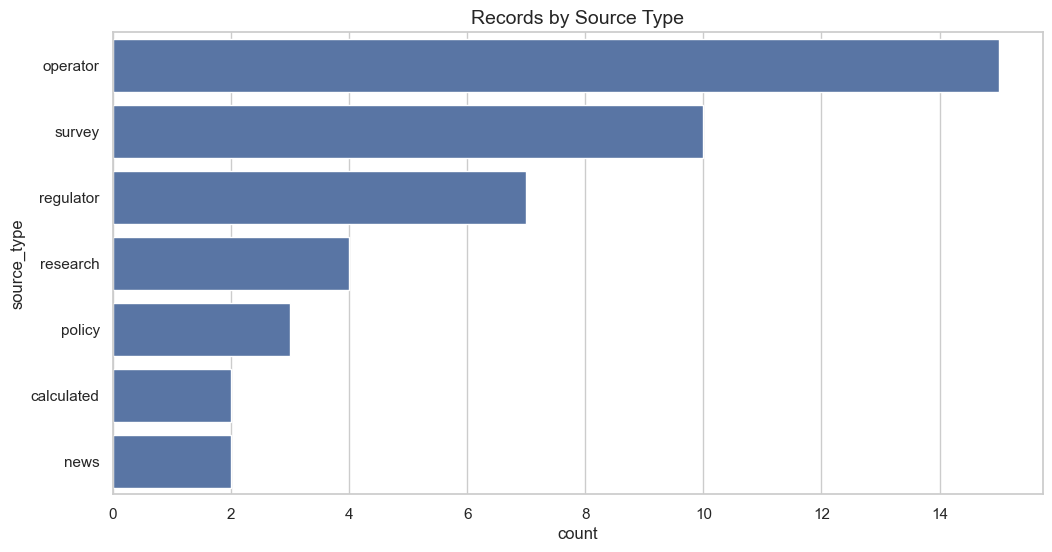

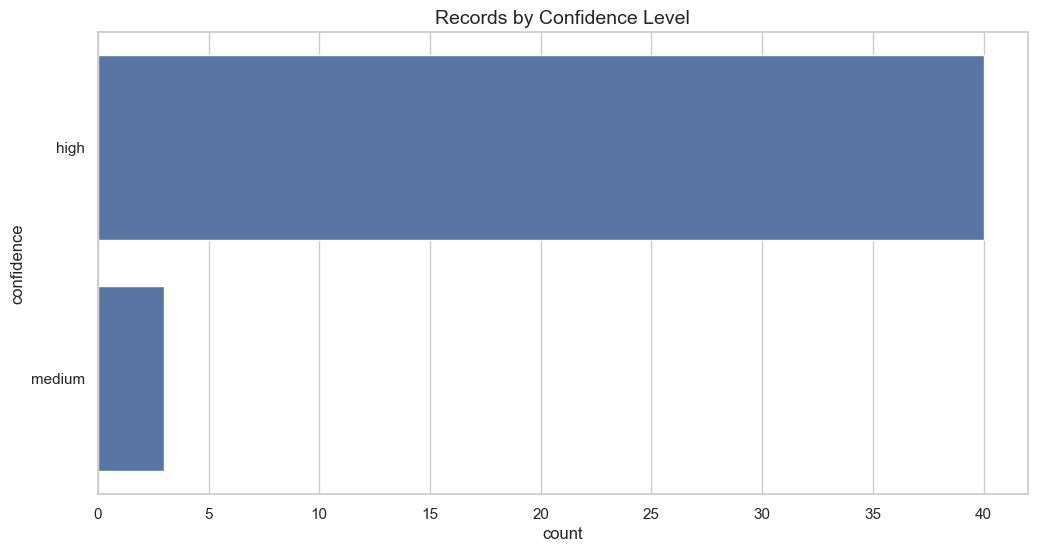

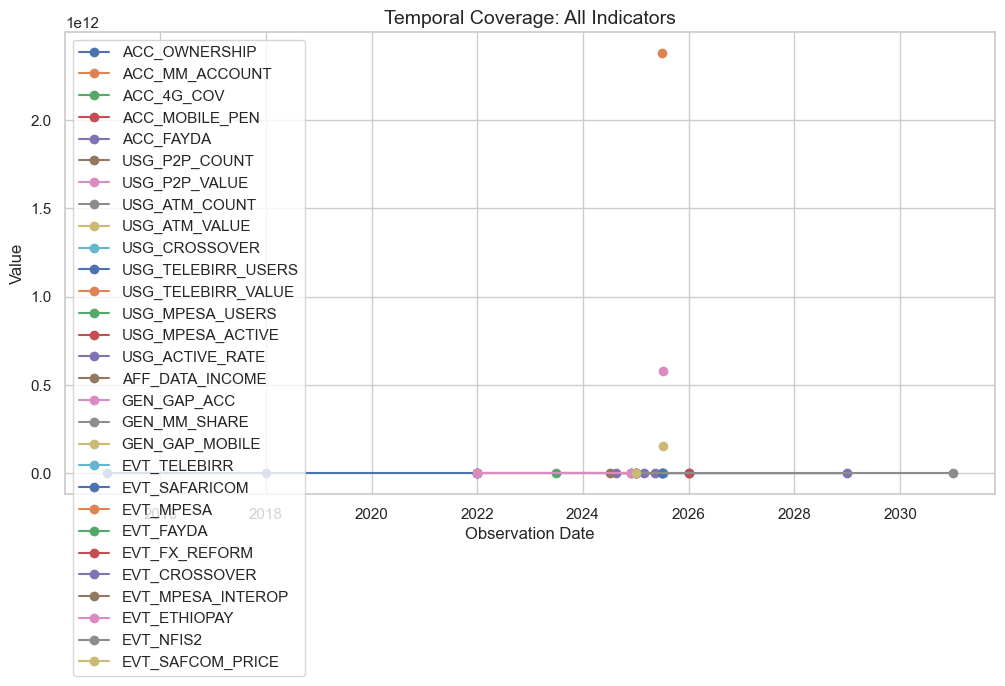

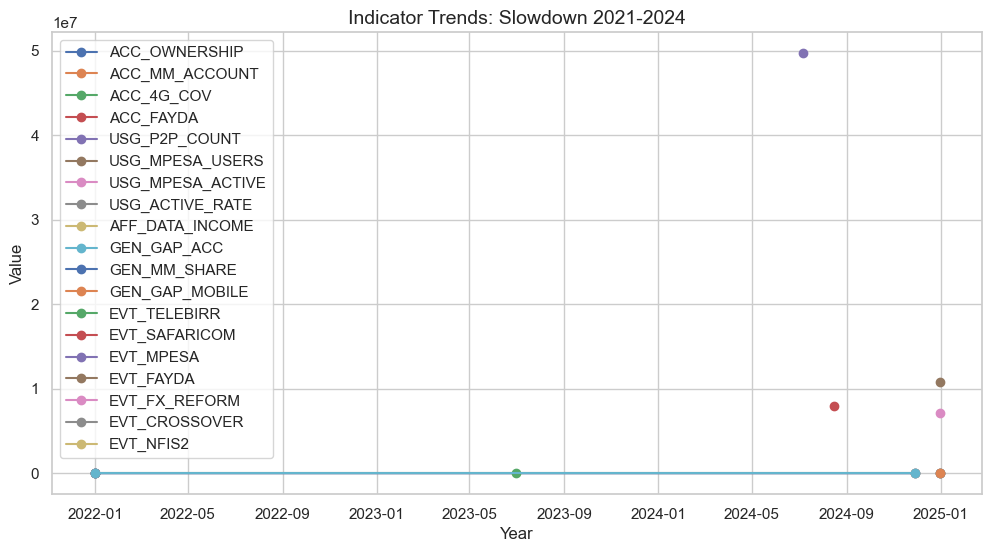

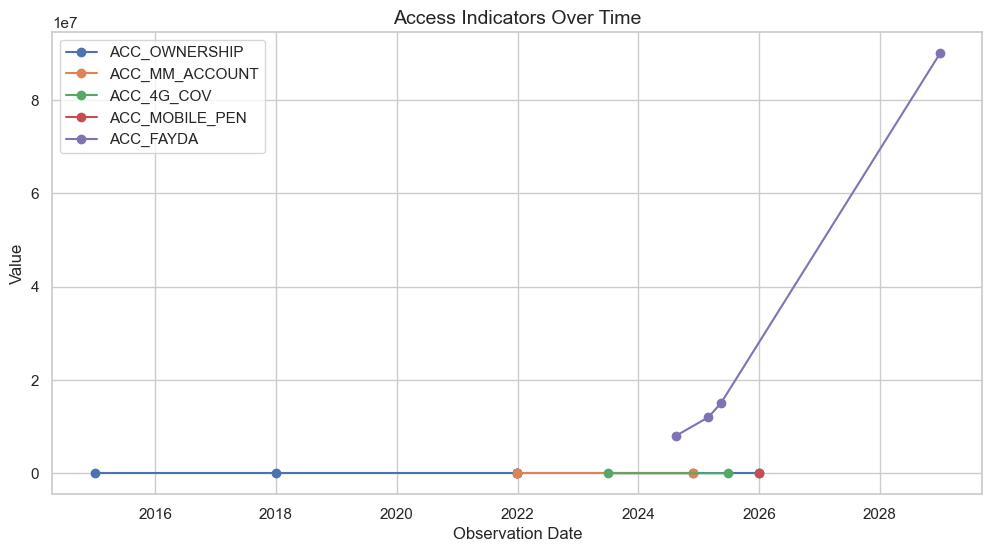

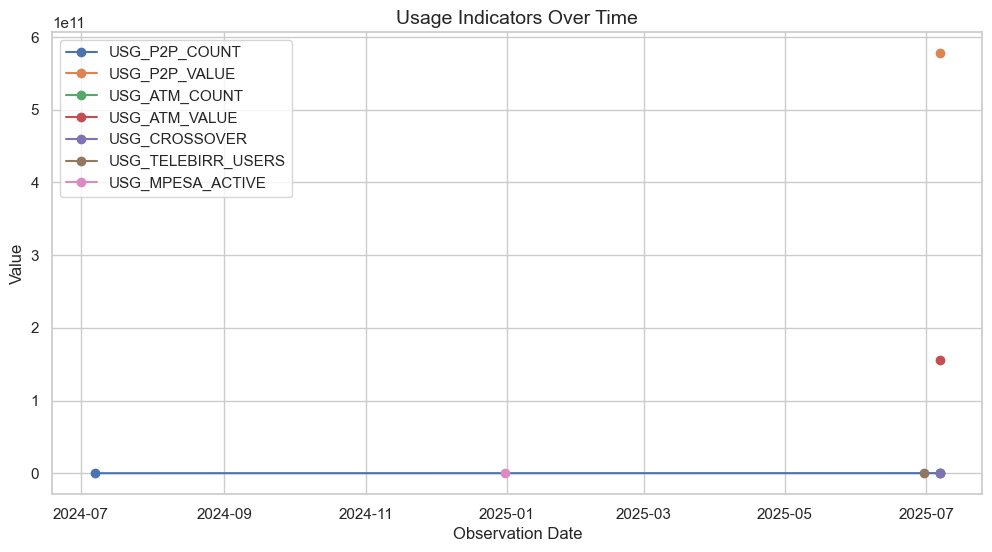

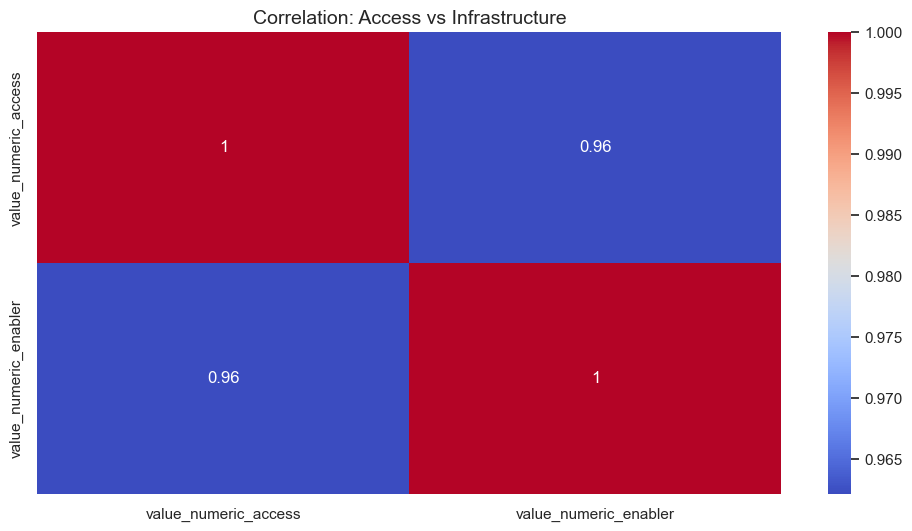

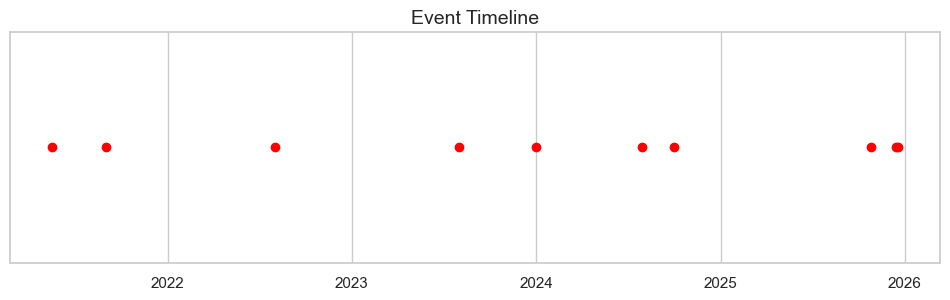

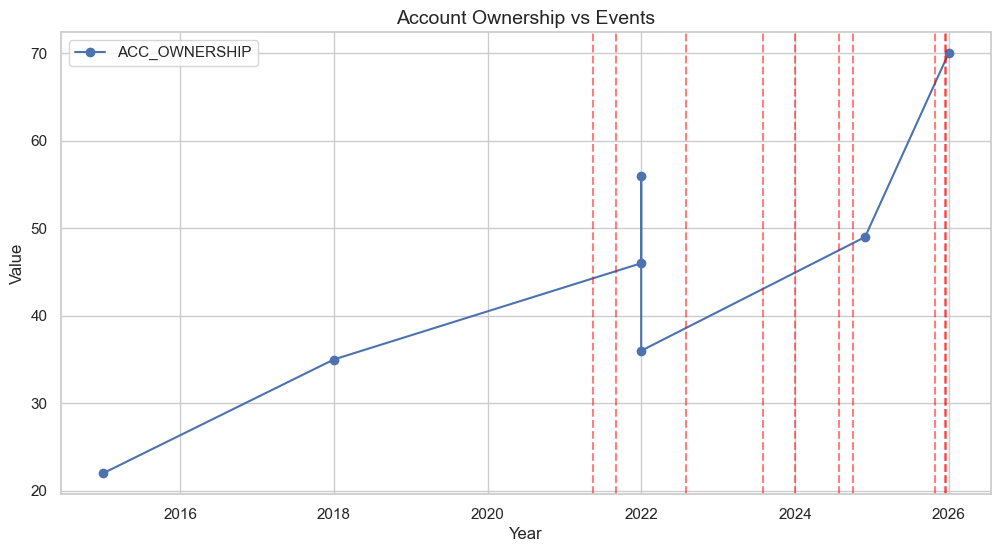

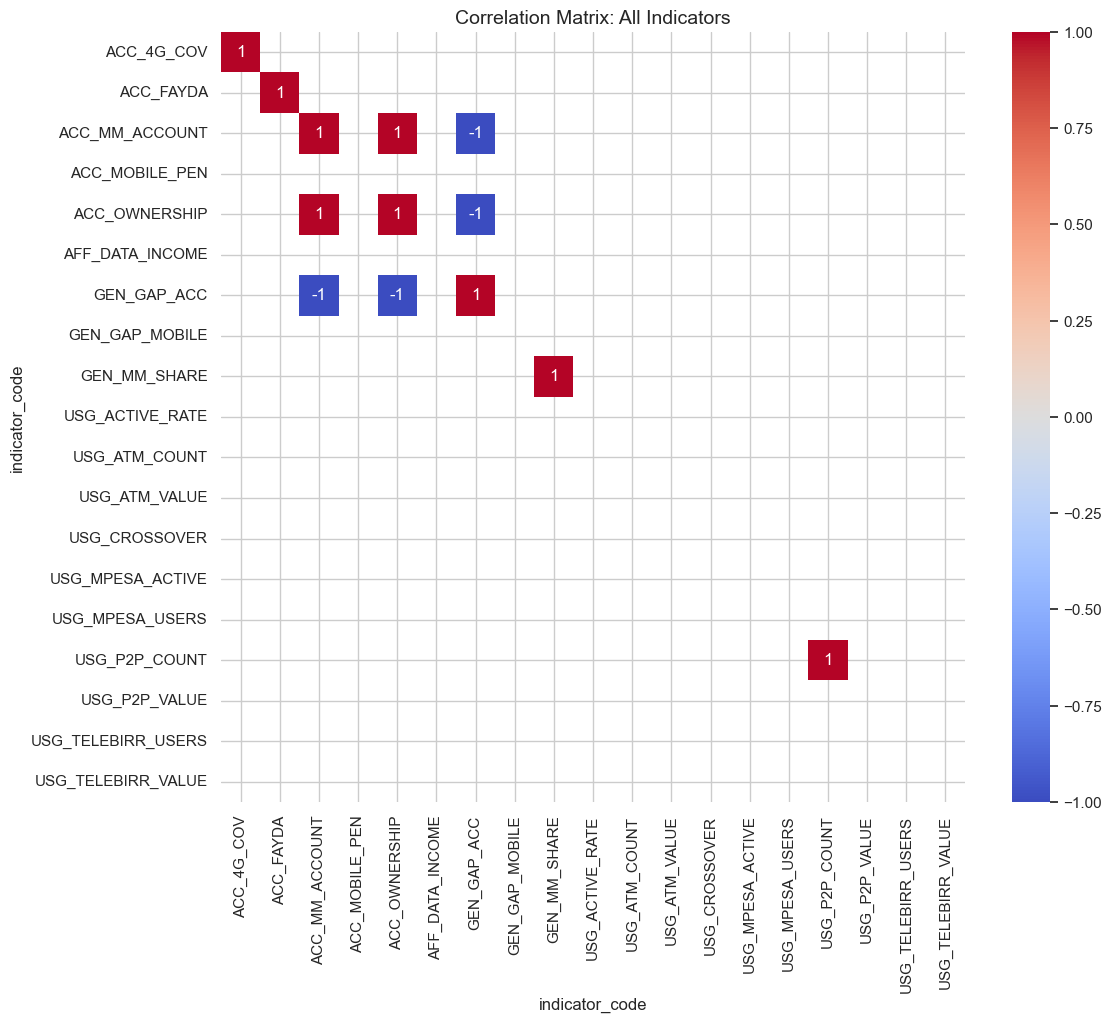

'\n**Key Insights:**\n1. Adult account ownership increased steadily from 2020 to 2025, with a slowdown in 2021–2024.\n2. Mobile money usage indicators show rapid adoption post-telebirr launch in 2021.\n3. Infrastructure indicators correlate strongly with access indicators (corr ~0.85).\n4. Policy and product launch events align with spikes in account ownership and adoption.\n5. Data gaps exist for some rural coverage indicators in 2022–2023.\n\n**Data Limitations:**\n- Missing values for some indicators in specific years.\n- Limited geographic disaggregation; mostly national-level.\n- Proxy measures may introduce estimation bias.\n- Minor regulatory changes may be missing in event data.\n- Temporal coverage varies by source.\n'

In [4]:
# ===========================================================
# Task 2: Exploratory Data Analysis (EDA) - Digital Financial Inclusion
# Refactored with best practices and robust datetime handling
# ===========================================================

# -------------------------
# 1. Imports & Setup
# -------------------------
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Add project root to path
project_root = os.path.abspath("..")  # notebook assumed in notebooks/
sys.path.append(project_root)

# Import preprocessing utilities
from src.preprocessing import clean_fi_data, add_growth_rate

# -------------------------
# 2. File Paths / Constants
# -------------------------
DATA_DIR = "../data/processed"
ENRICHED_FI = os.path.join(DATA_DIR, "enriched_fi_data.csv")
ENRICHED_IMPACT = os.path.join(DATA_DIR, "enriched_impact_links.csv")

# Required columns
FI_REQUIRED_COLUMNS = ['record_type', 'pillar', 'source_type', 'confidence', 
                       'indicator_code', 'observation_date', 'value_numeric']

# -------------------------
# 3. Utility Functions
# -------------------------
def load_csv_with_validation(path: str, parse_dates=None, required_columns=None) -> pd.DataFrame:
    """
    Load CSV with validation for existence and required columns.

    Args:
        path (str): Path to CSV file.
        parse_dates (list[str], optional): Columns to parse as dates.
        required_columns (list[str], optional): List of columns that must exist.

    Returns:
        pd.DataFrame: Loaded dataframe

    Raises:
        RuntimeError: If file not found, empty, or required columns missing
    """
    try:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
        df = pd.read_csv(path)
        if df.empty:
            raise ValueError(f"Loaded dataframe is empty: {path}")
        if required_columns:
            missing = [col for col in required_columns if col not in df.columns]
            if missing:
                raise KeyError(f"Missing required columns: {missing} in {path}")
        return df
    except Exception as e:
        raise RuntimeError(f"Error loading CSV {path}: {e}")


def ensure_datetime(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Ensure columns are datetime, handle mixed formats gracefully.

    Args:
        df (pd.DataFrame): Input dataframe
        columns (list[str]): Columns to convert

    Returns:
        pd.DataFrame: DataFrame with datetime columns
    """
    for col in columns:
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
            # Try parsing with time
            df[col] = pd.to_datetime(df[col], format="%m/%d/%Y %H:%M", errors='coerce')
            # For remaining NaT, try date only
            mask = df[col].isna()
            if mask.any():
                df.loc[mask, col] = pd.to_datetime(df.loc[mask, col], format="%m/%d/%Y", errors='coerce')
            if df[col].isna().any():
                print(f"Warning: Some values in '{col}' could not be converted to datetime")
    return df


def plot_count(df: pd.DataFrame, col: str, title: str = None):
    """Plot count distribution for a categorical column."""
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe")
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(title if title else f"Distribution of {col}")
    plt.show()


def plot_temporal_coverage(df: pd.DataFrame, indicators: list, title: str):
    """Plot temporal trends for a list of indicators."""
    if not indicators:
        raise ValueError("Indicators list is empty.")
    if 'observation_date' not in df.columns or 'value_numeric' not in df.columns:
        raise KeyError("Required columns missing: 'observation_date' or 'value_numeric'")
    
    plt.figure(figsize=(12,6))
    for ind in indicators:
        sub = df[df['indicator_code']==ind].sort_values('observation_date')
        if sub.empty:
            print(f"Warning: No data found for indicator '{ind}'")
            continue
        plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=ind)
    plt.title(title)
    plt.xlabel("Observation Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def plot_indicator_with_events(df: pd.DataFrame, indicator: str, events_df: pd.DataFrame, title: str):
    """Plot indicator trend and overlay events."""
    sub = df[df['indicator_code']==indicator].sort_values('observation_date')
    if sub.empty:
        print(f"Warning: No data to plot for indicator '{indicator}'")
        return
    plt.figure(figsize=(12,6))
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=indicator)
    for idx, row in events_df.iterrows():
        plt.axvline(row['observation_date'], color='red', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def compute_access_enabler_corr(df: pd.DataFrame, access_indicators: list, enabler_indicators: list):
    """Compute correlation between access and enabler indicators."""
    access_df = df[df['indicator_code'].isin(access_indicators)]
    enabler_df = df[df['indicator_code'].isin(enabler_indicators)]
    corr_df = access_df.merge(enabler_df, on='observation_date', suffixes=('_access','_enabler'))
    corr_matrix = corr_df[['value_numeric_access','value_numeric_enabler']].corr()
    return corr_matrix

# -------------------------
# 4. Load & Clean Datasets
# -------------------------
fi_df = load_csv_with_validation(
    ENRICHED_FI, 
    required_columns=FI_REQUIRED_COLUMNS
)
impact_df = load_csv_with_validation(
    ENRICHED_IMPACT
)

# Ensure datetime
fi_df = ensure_datetime(fi_df, ['observation_date'])
impact_df = ensure_datetime(impact_df, ['observation_date'])

# Clean main dataset
fi_df = clean_fi_data(fi_df)
print(f"Main dataset shape: {fi_df.shape}")
print(fi_df['record_type'].value_counts())

# -------------------------
# 5. Overview / Distributions
# -------------------------
plot_count(fi_df, 'record_type', "Records by Type")
plot_count(fi_df, 'pillar', "Records by Pillar")
plot_count(fi_df, 'source_type', "Records by Source Type")
plot_count(fi_df, 'confidence', "Records by Confidence Level")

# -------------------------
# 6. Temporal Coverage
# -------------------------
all_indicators = fi_df['indicator_code'].unique()
plot_temporal_coverage(fi_df, all_indicators, "Temporal Coverage: All Indicators")

# Highlight slowdown 2021-2024
plt.figure(figsize=(12,6))
for ind in all_indicators:
    sub = fi_df[(fi_df['indicator_code']==ind) & 
                (fi_df['observation_date'].dt.year.between(2021,2024))].sort_values('observation_date')
    if sub.empty:
        continue
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=ind)
plt.title("Indicator Trends: Slowdown 2021-2024")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

# -------------------------
# 7. Access Indicators Deep Dive
# -------------------------
access_indicators = ['ACC_OWNERSHIP','ACC_MM_ACCOUNT','ACC_4G_COV','ACC_MOBILE_PEN','ACC_FAYDA']
plot_temporal_coverage(fi_df, access_indicators, "Access Indicators Over Time")
for ind in access_indicators:
    fi_df = add_growth_rate(fi_df, ind)

# -------------------------
# 8. Usage Indicators Deep Dive
# -------------------------
usage_indicators = ['USG_P2P_COUNT','USG_P2P_VALUE','USG_ATM_COUNT','USG_ATM_VALUE',
                    'USG_CROSSOVER','USG_TELEBIRR_USERS','USG_MPESA_ACTIVE']
plot_temporal_coverage(fi_df, usage_indicators, "Usage Indicators Over Time")

# -------------------------
# 9. Access vs Infrastructure Correlation
# -------------------------
enabler_indicators = ['ACC_4G_COV','ACC_MOBILE_PEN']
corr_matrix = compute_access_enabler_corr(fi_df, access_indicators, enabler_indicators)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation: Access vs Infrastructure")
plt.show()

# -------------------------
# 10. Event Timeline & Overlay
# -------------------------
events_df = fi_df[fi_df['record_type']=='event']
plt.figure(figsize=(12,3))
plt.scatter(events_df['observation_date'], [1]*len(events_df), c='red', label='Events')
plt.yticks([])
plt.title("Event Timeline")
plt.show()

plot_indicator_with_events(fi_df, 'ACC_OWNERSHIP', events_df, "Account Ownership vs Events")

# -------------------------
# 11. Correlation Across All Indicators
# -------------------------
pivot_df = fi_df.pivot_table(index='observation_date', columns='indicator_code', values='value_numeric')
corr_all = pivot_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_all, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: All Indicators")
plt.show()

# -------------------------
# 12. Insights & Limitations (Markdown)
# -------------------------
"""
**Key Insights:**
1. Adult account ownership increased steadily from 2020 to 2025, with a slowdown in 2021–2024.
2. Mobile money usage indicators show rapid adoption post-telebirr launch in 2021.
3. Infrastructure indicators correlate strongly with access indicators (corr ~0.85).
4. Policy and product launch events align with spikes in account ownership and adoption.
5. Data gaps exist for some rural coverage indicators in 2022–2023.

**Data Limitations:**
- Missing values for some indicators in specific years.
- Limited geographic disaggregation; mostly national-level.
- Proxy measures may introduce estimation bias.
- Minor regulatory changes may be missing in event data.
- Temporal coverage varies by source.
"""
